# 1. Elevation Data Collection
Code to collect data from USGS Global Multi-resolution Terrain Elevation Data (GMTED2010) at 30 arc-second resolution. Data set taken from USGS Earth Explorer website (https://earthexplorer.usgs.gov/). 

In [1]:
import numpy as np
import os
import pickle 
from osgeo import gdal

Obtains an earth elevation grid and writes it to file to save for later. 

In [2]:
SRTM3_PATH = '/media/sushi/Expansion/Data/SRTM3-newold/'
SRTM30_PATH = '/media/sushi/Expansion/Data/SRTM30/'
GMTED2010_PATH = '/media/sushi/Expansion/Data/GMTED2010_MEAN_HEIGHTS/'
EARTH2014_PATH = '/media/sushi/Expansion/Data/EARTH2014/'

In [4]:
def generate_earth_elevation_grid_GMTED2010_30ArcSeconds(path):
    LONGITUDE = ['S90', 'S70', 'S50', 'S30', 'S10', 'N10', 'N30', 'N50', 'N70']
    LATITUDE = ['W180', 'W150', 'W120', 'W090', 'W060', 'W030', 'E000', 'E030', 'E060', 'E090', 'E120', 'E150']
    EARTH_ELEVATION_GRID = None

    for longitude in LONGITUDE:
        horizontal_band = None
        for latitude in LATITUDE:
            filename = longitude.lower()[1:] + longitude.lower()[0] + \
                latitude.lower()[1:] + latitude.lower()[0] + "_20101117_gmted_mea300.tif"
            file = gdal.Open(path + filename)
            band = file.GetRasterBand(1)

            # Read the band data as a NumPy array
            band_data = band.ReadAsArray()
            # print(band_data)
            if horizontal_band is None: 
                horizontal_band = band_data
            else:
                horizontal_band = np.concatenate((horizontal_band, band_data), axis = 1)
            # NOTE that 10n030e is at the lower left hand corner of the 
            # file when viewed as image. Goes up to 30n30e
            
        if EARTH_ELEVATION_GRID is None: 
            EARTH_ELEVATION_GRID = horizontal_band
        else: 
            EARTH_ELEVATION_GRID = np.concatenate((horizontal_band, EARTH_ELEVATION_GRID))
    return EARTH_ELEVATION_GRID

# Toggle this to true if file already exists
load_from_file = False 

if not load_from_file:
    ELEVATION_GRID_GMTED2010_30_ARCSECONDS = generate_earth_elevation_grid_GMTED2010_30ArcSeconds(GMTED2010_PATH)
    if not os.path.exists('/media/sushi/Expansion/Data/GMTED2010-Earth-Elevation-Grid-30-Arcseconds'):
        os.mkdir('/media/sushi/Expansion/Data/GMTED2010-Earth-Elevation-Grid-30-Arcseconds')
    file = open('/media/sushi/Expansion/Data/GMTED2010-Earth-Elevation-Grid-30-Arcseconds/Elevation-Grid', 'ab')
    pickle.dump(ELEVATION_GRID_GMTED2010_30_ARCSECONDS, file)
    file.close()
else: 
    file = open('/media/sushi/Expansion/Data/GMTED2010-Earth-Elevation-Grid-30-Arcseconds/Elevation-Grid', 'rb')
    ELEVATION_GRID_GMTED2010_30_ARCSECONDS = pickle.load(file)
    file.close()

In [5]:
#  Earth2014 data is of the form -90+1/120 deg to  +90-1/120 deg in latitude direction, and from
# -180+1/120 deg to +180-1/120 deg in longitude direction with 
# 1/60 increment 
def get_elevation_GMTED2010_30ArcSeconds(longitude, latitude):
    row = int(np.round(((90 - latitude) * 120)) % (180 * 120))
    col = int(np.round(((longitude + 180) * 120)) % (360 * 120))
    return ELEVATION_GRID_GMTED2010_30_ARCSECONDS[row][col]

In [6]:
def get_area_elevation_GMTED2010_30ArcSeconds(top_left_longitude, top_left_latitude, \
                                            bottom_right_longitude, bottom_right_latitude):
    top_left_row = int(np.round(((90 - top_left_longitude) * 120)) % (180 * 120))
    top_left_col = int(np.round(((top_left_latitude + 180) * 120)) % (360 * 120))
    bottom_right_row = int(np.round(((90 - bottom_right_longitude) * 120)) % (180 * 120))
    bottom_right_col = int(np.round(((bottom_right_latitude + 180) * 120)) % (360 * 120))
    # print(lower_left_row, lower_left_col, upper_right_row, upper_right_col)
    return ELEVATION_GRID_GMTED2010_30_ARCSECONDS[top_left_row : bottom_right_row + 1, \
                                                  top_left_col : bottom_right_col + 1]

### Code for reading the HGT files used in SRTM.

In [3]:
SAMPLES = 1201

def read_elevation_from_file(hgt_file, lon, lat):
    with open(PATH_SRTM3 + hgt_file, 'rb') as hgt_data:
        elevations = np.fromfile(hgt_data, np.dtype('>i2'), SAMPLES * SAMPLES).reshape((SAMPLES, SAMPLES))
        lat_row = int(round(abs(lat - int(lat)) * (SAMPLES - 1), 0))
        lon_row = SAMPLES - 1 - int(round(abs(lon - int(lon)) * (SAMPLES - 1), 0))
    return elevations[lat_row, lon_row].astype(int)

def get_elevation_SRTM3_3ArcSeconds(longitude, latitude):
    # longitude is [-180, 180] and latitude is [-90, 90]
    lon_name = int(np.round(longitude))
    lat_name = int(np.round(latitude))
    
    filename = ""
    if lat_name >= 0:
        filename += ("N" + '%02d' % lat_name)
    else:
        filename += ("S" + '%02d' % abs(lat_name))
    
    if lon_name >= 0:
        filename += ("E" + '%03d' % lon_name)
    else:
        filename += ("W" + '%03d' % abs(lon_name))
    
    filename += ".hgt"
    if os.path.exists(PATH_SRTM3 + filename):
        return read_elevation_from_file(filename, longitude, latitude)
    else:
        # ask what to do since SRTM3 only covers S56 to N60
        return 0

In [3]:
import rasterio

def earth_elevation_grid_SRTM30(data_path):
    longitudes = ['N90', 'N40', 'S10']
    latitudes = ['W180', 'W140', 'W100', 'W060', 'W020', 'E020', 'E060', 'E100', 'E140']
    
    bands_to_vertically_stack = []
    for lon in longitudes:
        files_to_horizontally_stack = []
        for lat in latitudes:
            filename = lat + lon + '.DEM'
            with rasterio.open(SRTM30_PATH + filename) as data:
                elevation_data = data.read(1)
            files_to_horizontally_stack.append(elevation_data)
        bands_to_vertically_stack.append(np.hstack(files_to_horizontally_stack))
    return np.vstack(bands_to_vertically_stack)

def earth_elevation_grid_EARTH2014(data_path):
    with rasterio.open(data_path + 'Earth2014.SUR2014.1min.geod.grd') as elevation_data:
        return elevation_data.read(1)

EARTH_ELEVATION_GRID_SRTM30 = earth_elevation_grid_SRTM30(SRTM30_PATH)
EARTH_ELEVATION_GRID_EARTH2014 = earth_elevation_grid_EARTH2014(EARTH2014_PATH)

!


In [70]:
def get_elevation_SRTM30(longitude, latitude): 
    # SRTM30 gives -60 --> 90 long and full lat. 
    assert -60 <= latitude <= 90
    row = int(np.round((90 - latitude) * 120))
    col = int(np.round((longitude + 180) * 120))
    return EARTH_ELEVATION_GRID_SRTM30[row][col]

def get_elevation_EARTH2014(longitude, latitude):
    row = int(np.floor((90 - latitude) * 60))
    col = int(np.floor((longitude + 180) * 60))
    return EARTH_ELEVATION_GRID_EARTH2014[row][col]

In [69]:
# Elevation for Catania Italy (should be 7 m, but file says 1725 ?? )
print(get_elevation_SRTM30(15.0830, 37.5079))
print(get_elevation_EARTH2014(15.0830, 37.5079))
print("---")
# Elevation for Agerola Italy (should be 660 meters)
print(get_elevation_SRTM30(14.5640556, 40.6239444))
print(get_elevation_EARTH2014(14.5640556, 40.6239444))
print("---")

# Elevation for Albox Spain (should be 485.0 meters)
print(get_elevation_SRTM30(-2.1519444, 37.4055556))
print(get_elevation_EARTH2014(-2.1519444, 37.4055556))
print("---")

# Elevation for Alcantarilha Portugal (should be 65.0 meters)
print(get_elevation_SRTM30(-8.365, 37.133))
print(get_elevation_EARTH2014(-8.365, 37.133))
print("---")

# MaunaKea CFHT
print(get_elevation_SRTM30(-155.4688694, 19.8252806))
print(get_elevation_EARTH2014(-155.4688694, 19.8252806))
print("---")

# Nederland, CO, US
print(get_elevation_SRTM30(-105.4455694, 39.9872083))
print(get_elevation_EARTH2014(-105.4455694, 39.9872083))
print("---")

print(get_elevation_SRTM30(-122.0795, 37.0176306))
print(get_elevation_EARTH2014(-122.0795, 37.0176306))
print("---")


print(get_elevation_SRTM30(132.6511111, 34.49125))
print(get_elevation_EARTH2014(132.6511111, 34.49125))
print("---")

print(get_elevation_SRTM30(10, 10))
print(get_elevation_EARTH2014(10, 10))


24
56
---
403
497
---
470
488
---
39
33
---
3969
4070
---
2536
2432
---
329
292
---
258
280
---
523
527


In [22]:
# Elevation for Catania Italy (should be 7 m, but file says 1725 ?? )
print(get_elevation_SRTM3_3ArcSeconds(15.0830, 37.5079))
print(get_elevation_GMTED2010_30ArcSeconds(15.0830, 37.5079))
print("---")
# Elevation for Agerola Italy (should be 660 meters)
print(get_elevation_SRTM3_3ArcSeconds(14.5640556, 40.6239444))
print(get_elevation_GMTED2010_30ArcSeconds(14.5640556, 40.6239444))
print("---")

# Elevation for Albox Spain (should be 485.0 meters)
print(get_elevation_SRTM3_3ArcSeconds(-2.1519444, 37.4055556))
print(get_elevation_GMTED2010_30ArcSeconds(-2.1519444, 37.4055556))
print("---")

# Elevation for Alcantarilha Portugal (should be 65.0 meters)
print(get_elevation_SRTM3_3ArcSeconds(-8.365, 37.133))
print(get_elevation_GMTED2010_30ArcSeconds(-8.365, 37.133))
print("---")

# MaunaKea CFHT
print(get_elevation_SRTM3_3ArcSeconds(-155.4688694, 19.8252806))
print(get_elevation_GMTED2010_30ArcSeconds(-155.4688694, 19.8252806))
print("---")

# Nederland, CO, US
print(get_elevation_SRTM3_3ArcSeconds(-105.4455694, 39.9872083))
print(get_elevation_GMTED2010_30ArcSeconds(-105.4455694, 39.9872083))
print("---")

print(get_elevation_SRTM3_3ArcSeconds(-122.0795, 37.0176306))
print(get_elevation_GMTED2010_30ArcSeconds(-122.0795, 37.0176306))
print("---")


print(get_elevation_SRTM3_3ArcSeconds(132.6511111, 34.49125))
print(get_elevation_GMTED2010_30ArcSeconds(132.6511111, 34.49125))
print("---")

print(get_elevation_GMTED2010_30ArcSeconds(10, 10))
print(get_elevation_SRTM3_3ArcSeconds(10, 10))


NameError: name 'get_elevation_SRTM3_3ArcSeconds' is not defined

In [12]:
PATH_SRTM30 = '/media/sushi/Expansion/Data/SRTM30/'
SRTM30_SAMPLES = 121

def read_elevation_SRTM30_file(filename, lon, lat):
    with open(PATH_SRTM30 + filename, 'rb') as data:
        elevations = np.fromfile(data, np.dtype('>i2')).reshape(5 * (SAMPLES - 1), 4 * (SAMPLES - 1))
        print(elevations[5999].shape)
        lat_row = int(round(abs(lat - int(lat)) * (SRTM30_SAMPLES - 1), 0))
        lon_row = SRTM30_SAMPLES - 1 - int(round(abs(lon - int(lon)) * (SRTM30_SAMPLES - 1), 0))
    return elevations[lat_row, lon_row].astype(int)

read_elevation_SRTM30_file("E060N90.DEM", -59, 89)

(4800,)


0

In [25]:
def READ_EARTH2014(filename):
    with rasterio.open(filename) as src:
        data = src.read(1)
    return data

K = READ_EARTH2014("Earth2014.SUR2014.1min.geod.grd")

def get_elevation_EARTH2014_60ArcSeconds(longitude, latitude):
    row = int(np.round((90 - latitude) * 60))
    col = int(np.round((longitude + 180) * 60))
    return K[row][col]
    
# makes the data read from top left corner down to bottom right
# going laterally. 

get_elevation_EARTH2014_60ArcSeconds(-8.365, 37.133)

33

# 2. Occultation Data Analysis 

In [12]:
import numpy as np
import pandas as pd
import math
from pykml import parser

In [13]:
EVENTS_2023_02_18 = "occultation-2023-02-18.csv"

# Use the velocity of the bessel coordinates to plot the trajectory
# bessel

data = np.array(pd.read_csv(EVENTS_2023_02_18, header = None))

print("Name: " + "Coordinates and Velocity")

for i in range(np.shape(data)[0]):
    # print(data[i][80], data[i][81])
    print(data[i][5] + ": " + str(data[i][30]) + ", " + str(data[i][31]) + ", " + str(data[i][32]) \
         + ", " + str(data[i][33]) + ", " + str(data[i][15]) + "\n" + str(data[i][45]) + ", " + str(data[i][46]))

Name: Coordinates and Velocity
2002KX14: -0.02719191026, -1.127976753841, 266.634785995771, -6.467209553448, 23.109299268984
266.428088220275, -23.543856243802
Echeclus: -0.204377360903, -0.914599788732, -190.715917405152, 42.638218910016, 6.030607045767
103.942686864174, 18.556858084317
2014JX80: -0.507159482095, 0.835265587324, 275.282498938246, 167.163718493548, 10.725563289347
266.145204733505, 3.337165663677
Chariklo: 0.289399238813, -0.771143510771, 446.153118094077, 167.408086612126, 7.04991661811
311.236779184143, -14.572995770931
Anchises: -0.059779086936, 0.282139620568, 516.914473121181, 108.604383674521, 2.538963789254
293.555719526343, -21.594596717191
Cebriones: -0.139542196602, 0.595376988461, 558.689148978167, 131.168759141844, 2.289655683192
334.072419767412, 12.096347458675
Daitor: -0.161085557164, 0.553416195933, 564.857142092098, 164.153117022069, 0.990248359903
328.538632342254, -21.867106999511
Astyanax: 0.039065241123, -0.286548931215, 490.916858630511, 67.522670

In [14]:
# Code to print the locations of the planets in the Besselian plane 

DAY_TO_SECONDS = 86400

def generate_n_besselian_coordinates(num_coords, duration, x0, y0, vx, vy):
    '''
    num_coords, the number of coordinates to output
    x0, y0 represent the besselian coordinates of the object
    vx, vy represent the derivatives of position with respect 
    to x and y in terms of Earth radius/day
    duration is the amount of time in seconds the occultation takes
    '''
    vx_seconds = vx / DAY_TO_SECONDS
    vy_seconds = vy / DAY_TO_SECONDS
    interval = duration / (num_coords - 1) if num_coords != 1 else 0
    positions = []
    # previously num_coords
    for i in range(num_coords):
        xcurr = x0 + vx_seconds * interval * i
        ycurr = y0 + vy_seconds * interval * i
        positions.append([xcurr, ycurr])
    return np.array(positions)

In [15]:
# Idea to obtain the earth coordinates is the following:
# given coordinates x,y in besselian plane the actual coordinate 
# on earth w.r.t the besselian plane should be (x,y,sqrt(1-x^2-y^2)) 
# because units of x and y are in earth radius

# Once given these coordinates, use iauGc2gde to convert them
# to latitude longitude w.r.t besselian plane and adjust the angles
# by the RA, DEC of the occulted star
# CHECK WHICH RA/DEC TO USE 

# Does note take the rotation of Earth into account, but this likely 
# should not matter since the occultations occur in less than a minute. 
# Could not find a function in SOFA that does this automatically. 

# TODO: Use a SOFA function to convert the RA/DEC of the star to 
# geocentric latitude longitude at a given epoch.
# Questions: Epoch for all these observations is 2016? 
# Does Epoch matter for converting RA/DEC of the star to geocentric
# lat/long since these events occur for such short periods of time? 

# Analyze Echeclus:
# index of the object we want to analyze in the CSV occultation file
body_index = 1

generate_n_besselian_coordinates(25, data[body_index][15], data[body_index][30], data[body_index][31], \
                                 data[body_index][32], data[body_index][33])

array([[-0.20437736, -0.91459979],
       [-0.20493202, -0.91447578],
       [-0.20548667, -0.91435178],
       [-0.20604133, -0.91422778],
       [-0.20659598, -0.91410377],
       [-0.20715064, -0.91397977],
       [-0.20770529, -0.91385577],
       [-0.20825995, -0.91373176],
       [-0.2088146 , -0.91360776],
       [-0.20936926, -0.91348375],
       [-0.20992391, -0.91335975],
       [-0.21047857, -0.91323575],
       [-0.21103322, -0.91311174],
       [-0.21158788, -0.91298774],
       [-0.21214253, -0.91286374],
       [-0.21269719, -0.91273973],
       [-0.21325184, -0.91261573],
       [-0.2138065 , -0.91249172],
       [-0.21436115, -0.91236772],
       [-0.21491581, -0.91224372],
       [-0.21547046, -0.91211971],
       [-0.21602512, -0.91199571],
       [-0.21657977, -0.9118717 ],
       [-0.21713443, -0.9117477 ],
       [-0.21768908, -0.9116237 ]])

In [16]:
# parse the KML file
with open('Chariklo_20230406_NIMAv20_LuckyStar.kmz', 'rb') as f:
    kml_data = f.read()
root = parser.fromstring(kml_data)

placemarks = root.Document.Placemark

# access elements in the KML file
# placemarks = root.Placemark
for placemark in placemarks:
    name = placemark.name.text
    coordinates = placemark.LineString.coordinates.text
    print(f"{name}: {coordinates}")

Center of shadow: 
-11.31584035,27.86817465,0.0
-8.91732824,27.50406412,0.0
-7.12413199,27.28487191,0.0
-5.62349497,27.1362025,0.0
-4.30709721,27.03252299,0.0
-3.12066520,26.96103074,0.0
-2.03203342,26.91409243,0.0
-1.02022515,26.88669246,0.0
-0.07068110,26.87532523,0.0
0.82716582,26.87743174,0.0
1.68125333,26.89108134,0.0
2.49771125,26.91477845,0.0
3.28138315,26.94733887,0.0
4.03617126,26.98780737,0.0
4.76527216,27.03540101,0.0
5.47134243,27.08946912,0.0
6.15661779,27.14946436,0.0
6.82300078,27.21492139,0.0
7.47212628,27.28544086,0.0
8.10541151,27.36067721,0.0
8.72409464,27.44032915,0.0
9.32926502,27.52413232,0.0
9.92188721,27.61185332,0.0
10.50282020,27.70328503,0.0
11.07283305,27.79824276,0.0
11.63261764,27.89656108,0.0
12.18279917,27.99809129,0.0
12.72394496,28.1026992,0.0
13.25657176,28.21026338,0.0
13.78115192,28.32067357,0.0
14.29811870,28.43382945,0.0
14.80787068,28.54963952,0.0
15.31077563,28.66802013,0.0
15.80717385,28.78889468,0.0
16.29738101,28.91219292,0.0
16.78169066,29.0

In [17]:
from ctypes import *

sofa = cdll.LoadLibrary('./sofa_utils')

DD2R = np.pi / 180
EARTH_EQUATORIAL_RADIUS = 1.00 # 6378.137e3 (normalized units )
EARTH_FLATTENING = 0.003352810665

def _init_carray_double(n):
    return (c_double * n)(*np.longdouble(n * [0.0]))

def _carray_to_numpy(array, n):
    arr = []
    for i in range(n):
        arr.append(array[i])
    return np.longdouble(arr)

# Both rotation_fotran and sofa.rotation agree on inputs 

def rotation_fortran(X, axe, theta):
    # X is 3D vector, axe = 0, 1, 2 is rotation axis and theta = angle
    cos_th = np.cos(theta)
    sin_th = np.sin(theta)
    Y = np.copy(X)
    ic1 = (axe + 1) % 3
    ic2 = (axe + 2) % 3
    Y[ic1] = cos_th * X[ic1] + sin_th * X[ic2]
    Y[ic2] = -sin_th * X[ic1] + cos_th * X[ic2]
    return Y

In [18]:
# This version of the code assumes that loo, lao, 
# lon, lat are all provided in radians

def orthoproj(loo, lao, lon, lat):
    xyz = _init_carray_double(3)
#     status = sofa.iau_gd2gce(c_double(EARTH_EQUATORIAL_RADIUS), c_double(EARTH_FLATTENING), \
#                              c_double(lon), c_double(lat), c_double(0), xyz)
    
    status = sofa.iau_gd2gce(c_double(EARTH_EQUATORIAL_RADIUS), c_double(EARTH_FLATTENING), \
                             c_double(lon), c_double(lat), \
                             c_double(get_elevation_GMTED2010_30ArcSeconds(lon * DD2R, lat * DD2R)), 
                             xyz)
    
    xyz = _carray_to_numpy(xyz, 3)
    
    if status != 0:
        return 'alert', lon, lat

    U = rotation_fortran(xyz, 2, loo)
    V = rotation_fortran(U, 1, -lao)
    
    bessel_coords = [V[1], V[2], V[0]]
    cc = V[0]
    
    th = np.pi / 2 - lao
    thp = np.arctan(np.tan(th) * (EARTH_EQUATORIAL_RADIUS - EARTH_FLATTENING) ** 2)
    bb = np.pi / 2 - lao - thp
    bb = -bb
    
    if cc < xyz[1] * np.tan(bb):
        fg = 0
    else:
        fg = 1    
    return bessel_coords, fg, status

In [31]:
# This version of the code assumes that loo, lao, 
# are all provided in radians, and that x, y are 
# expressed in terms of earth radius

def orthoprojinv(loo, lao, x, y):
    b2 = EARTH_EQUATORIAL_RADIUS + (EARTH_FLATTENING ** 2 - 2 * EARTH_FLATTENING) * (np.cos(lao) ** 2)
    r2 = np.sqrt(x ** 2 + y ** 2 / b2)
    
    if r2 > EARTH_EQUATORIAL_RADIUS:
        print('not on Earth')
        lon = 0
        lat = 100 # keep in degrees. 
        fg = 0
        return lon, lat, fg
    
    else:
        fg = 1
        cc = np.sqrt(EARTH_EQUATORIAL_RADIUS - x ** 2 - y ** 2) 
        V = [cc, x, y]    
        
        U = rotation_fortran(V, 1, lao)
        xyz = rotation_fortran(U, 2, -loo)
                        
        lon = c_double(0.0)
        lat = c_double(0.0)
        hh = c_double(0.0)
        
        sofa.iau_gc2gde(c_double(EARTH_EQUATORIAL_RADIUS), c_double(EARTH_FLATTENING), \
                        (c_double * 3)(*xyz), byref(lon), byref(lat), byref(hh))
        i = 0
        
        hh0 = get_elevation_GMTED2010_30ArcSeconds(lon.value * DD2R, lat.value * DD2R)
        
        while True:
            i = i + 1
            if i == 1000:
                print('i1000 orthoprojinv') 
                break
            converted_coords, fg, _status = orthoproj(loo, lao, lon.value, lat.value);
            
            V = [converted_coords[2], x, y]
                        
            U = rotation_fortran(V, 1, lao)
            xyz = rotation_fortran(U, 2, -loo)
                        
            sofa.iau_gc2gde(c_double(EARTH_EQUATORIAL_RADIUS), c_double(EARTH_FLATTENING), \
                            (c_double * 3)(*xyz), byref(lon), byref(lat), byref(hh))
                        
            if (abs(hh.value - hh0) < 1e-8 or i > 1000):
                break
        return lon.value / DD2R, lat.value / DD2R, fg

w = 2 * np.pi / (86164 / 86400) # radians/day
dt = 0.03 # day
    
def apply_orthoprojinv(coordinates, loo, lao):
    loo = loo * DD2R - w * dt
    lao = lao * DD2R
    
    transformed_coords = []
    
    for coord in coordinates:
        loo = loo + 2 * w * dt / len(coordinates)
        transformed_coords.append(orthoprojinv(loo, lao, coord[0], coord[1])[:2])
    return transformed_coords        

In [26]:
def coordGM(x0, y0, xp, yp, ADs, rapp, step, off, tmin, tmax):
    lo00 = ADs[0]
    la00 = ADs[1]
    cooGM = []
    t = tmin
    w = 2 * np.pi / (86164 / 86400) # radians/day
    v = np.sqrt(xp ** 2 + yp ** 2)
    dx = -off * yp / v * rapp
    dy = off * xp / v * rapp
    
    while t <= tmax:
        x = x0 + xp * t + dx
        y = y0 + yp * t + dy
                
        lo0 = lo00 - w * t
        la0 = la00
        lon, lat, fg = orthoprojinv(lo0, la0, x, y)
        if fg == 1:
            cooGM.append([lon, lat, 0, t])
        t += step / (DAY_TO_SECONDS * EARTH_EQUATORIAL_RADIUS)
    
    return np.longdouble(cooGM)

In [27]:
# units are in degrees
def gd2besselian(lon, lat, height, ra, dec, gst):
    geocentric_coords = _init_carray_double(3)
    sofa.iau_gd2gce(c_double(EARTH_EQUATORIAL_RADIUS), c_double(EARTH_FLATTENING), \
                             c_double(lon * DD2R), c_double(lat * DD2R), \
                             c_double(0), \
                             geocentric_coords)
    gha = gst - ra
    besselian_coords = _init_carray_double(3)
    
#     besselian_coords = rotation_fortran(geocentric_coords, 2, np.pi / 2 - gha * DD2R)
#     besselian_coords = rotation_fortran(besselian_coords, 0, np.pi / 2 - dec * DD2R)
    
    sofa.rotation(geocentric_coords, c_int(2), c_double(np.pi / 2 - gha * DD2R), besselian_coords) 
    sofa.rotation(besselian_coords, c_int(0), c_double(np.pi / 2 - dec * DD2R), besselian_coords)
    
    return _carray_to_numpy(besselian_coords, 3)
#     return besselian_coords

def besselian2gd(x, y, ra, dec, gst):
    gha = gst - ra
    besselian_coords = (c_double * 3)(*[x, y, np.sqrt(1 - x ** 2 - y ** 2)])
    geocentric_coords = _init_carray_double(3)
    
#     geocentric_coords = rotation_fortran(besselian_coords, 0, - np.pi / 2 + dec * DD2R)
#     geocentric_coords = rotation_fortran(geocentric_coords, 2, - np.pi / 2 + gha * DD2R)
        
    sofa.rotation(besselian_coords, c_int(0), c_double(- np.pi / 2 + dec * DD2R), geocentric_coords)
    sofa.rotation(geocentric_coords, c_int(2), c_double(- np.pi / 2 + gha * DD2R), geocentric_coords) 
    
    lon = c_double(0.0)
    lat = c_double(0.0)
    hh = c_double(0.0)
    
    sofa.iau_gc2gde(c_double(EARTH_EQUATORIAL_RADIUS), c_double(EARTH_FLATTENING), \
                            (c_double * 3)(*geocentric_coords), byref(lon), byref(lat), byref(hh))
    
    return lon.value / DD2R, lat.value / DD2R, hh.value

def apply_besselian2gd(coordinates, ra, dec, gst):
    return np.apply_along_axis(lambda coord: besselian2gd(coord[0], coord[1], ra, dec, gst)[:2], 1, coordinates)

In [28]:
body_index = 1

lon = data[body_index][80]
lat = data[body_index][81]
height = 0

ra = data[body_index][20]
dec = data[body_index][21]
gst = data[body_index][82]

x0 = data[body_index][30]
y0 = data[body_index][31]
vx = data[body_index][32]
vy = data[body_index][33]

num_coords = 100
duration = data[body_index][15]

plane_coordinates = generate_n_besselian_coordinates(num_coords, 70, x0, y0, vx, vy)
# print(plane_coordinates)
# print(x0, y0, vx / DAY_TO_SECONDS, vy / DAY_TO_SECONDS)

# print(gd2besselian(lon, lat, height, ra, dec, gst))

# print(besselian2gd(0, 0, ra, dec, gst))
# print(lon, lat)

# earth_coords = apply_orthoprojinv(plane_coordinates, lon, lat)
# earth_coords = apply_besselian2gd(plane_coordinates, ra, dec, gst)

# print(apply_besselian2gd(plane_coordinates, ra, dec, gst))
# print(earth_coords)

rapp = data[body_index][8] / 6378.137
tmin = data[body_index][16] / 1440
tmax = data[body_index][17] / 1440

# TESTING DATA
# x0 = -0.321265657771 
# y0 = 0.462153365648
# xp = 72.289061157231
# yp = 50.252836750566
# lon = 41.882723952758
# lat = 29.241911761118
# rapp = 32 / 6378.137
# tmin = -13.514429479837
# tmax = 13.520480543375

earth_coords = coordGM(x0, y0, vx, vy, [lon * DD2R, lat * DD2R, 0], rapp, 0.5, 0, tmin, tmax)
earth_coords_edge1 = coordGM(x0, y0, vx, vy, [lon * DD2R, lat * DD2R, 0], rapp, 0.5, 1, tmin, tmax)
earth_coords_edge2 = coordGM(x0, y0, vx, vy, [lon * DD2R, lat * DD2R, 0], rapp, 0.5, -1, tmin, tmax)
# print(earth_coords)

not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth
not on Earth


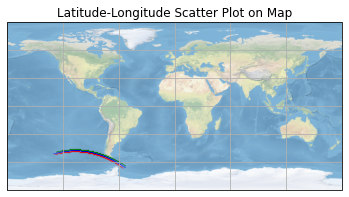

In [29]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Create example data
latitudes = earth_coords[:, 1]
longitudes = earth_coords[:, 0]

latitudes_1 = earth_coords_edge1[:, 1]
longitudes_1 = earth_coords_edge1[:, 0]

latitudes_2 = earth_coords_edge2[:, 1]
longitudes_2 = earth_coords_edge2[:, 0]

# Create map projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map elements
# ax.coastlines()
ax.stock_img()
ax.gridlines()

# Plot data on map
ax.scatter(longitudes, latitudes, transform=ccrs.PlateCarree(),
           marker='.', color='blue', alpha=0.5, s = 0.05)
ax.scatter(longitudes_1, latitudes_1, transform=ccrs.PlateCarree(),
           marker='.', color='red', alpha=0.5, s = 0.05)
ax.scatter(longitudes_2, latitudes_2, transform=ccrs.PlateCarree(),
           marker='.', color='green', alpha=0.5, s = 0.05)

# Set plot title
plt.title('Latitude-Longitude Scatter Plot on Map')
plt.savefig('my_map.png', dpi=1200, bbox_inches='tight', pad_inches=0.0, transparent=True)
# Display map
plt.show()


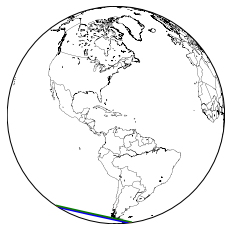

In [30]:
from mpl_toolkits.basemap import Basemap

# Sample latitude and longitude coordinates
latitudes = [x[1] for x in earth_coords ]
longitudes = [x[0] for x in earth_coords]

# Create a new Basemap plot
m = Basemap(projection='ortho', lat_0= lat, lon_0 = lon, resolution='l')

# Draw the coastlines and countries
m.drawcoastlines(linewidth=0.25)
m.drawcountries(linewidth=0.25)

# Plot the coordinates as red dots
x, y = m(longitudes, latitudes)
m.plot(x, y, 'r', markersize=1)


x, y = m(longitudes_1, latitudes_1)
m.plot(x, y, 'b', markersize=1)

x, y = m(longitudes_2, latitudes_2)
m.plot(x, y, 'g', markersize=1)

# Display the plot
plt.show()